In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import urllib
import itertools
import random, os, glob
import zipfile
import shutil
import h5py
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import  ModelCheckpoint
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D, BatchNormalization, GlobalAveragePooling2D, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir_path = "/content/drive/My Drive/Skripsi/Program/Garbage classification/Garbage classification"

print(os.listdir(dir_path))

['cardboard', 'trash', 'glass', 'paper', 'metal', 'plastic']


In [4]:
target_size = (224, 224)
waste_labels = {"cardboard":0, "glass":1, "metal":2, "paper":3, "plastic":4, "trash":5}

def load_dataset(path, target_size):
    x = []
    labels = []
    image_paths = sorted(list(paths.list_images(path)))
    for image_path in image_paths:
        img = cv2.imread(image_path)
        img = cv2.resize(img, target_size)
        x.append(img)
        label = image_path.split(os.path.sep)[-2]
        labels.append(waste_labels[label])
    x, labels = shuffle(x, labels, random_state=42)
    input_shape = (target_size[0], target_size[1], 3)
    print("X shape:", np.array(x).shape)
    print("Total Class:", len(np.unique(labels)))
    print("Total Data:", len(labels))
    print("Input Shape:", input_shape)
    return x, labels, input_shape

x, labels, input_shape = load_dataset(dir_path, target_size)

X shape: (2527, 224, 224, 3)
Total Class: 6
Total Data: 2527
Input Shape: (224, 224, 3)


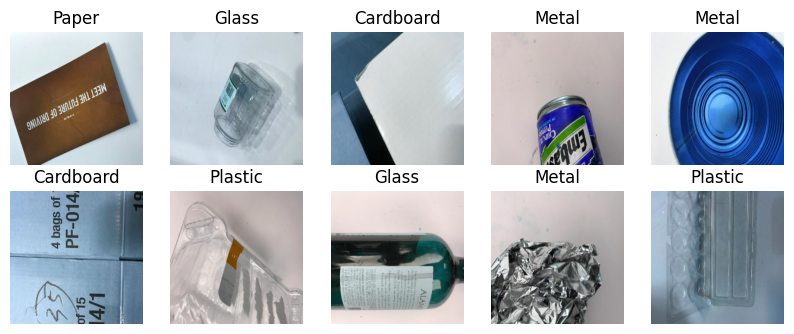

In [5]:
def visualize_img(image_batch, labels, num_of_img):
    plt.figure(figsize=(10, 10))
    for n in range(num_of_img):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=len(np.unique(labels)))[n] == 1][0].title())
        plt.axis("off")

visualize_img(x, labels, 10)

In [6]:
def CNN_data_preparation():
    train = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
    )
    train_generator = train.flow_from_directory(
        directory=dir_path,
        target_size=(target_size),
        batch_size=32,
        class_mode="categorical",
        subset="training"
    )

    return train_generator


train_generator = CNN_data_preparation()

Found 2527 images belonging to 6 classes.


In [7]:
n_splits = 5

train_metrics = []
val_metrics = []
all_classification_reports = []
all_confusion_matrices = []
all_validation_labels = []
all_validation_predictions = []

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [8]:
img_shape = (224, 224, 3)

base_model = tf.keras.applications.ResNet50(input_shape=img_shape,
                                            include_top=False,
                                            weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

# base_model.summary()

94765736/94765736 [==============================] - 1s 0us/step


In [9]:
def generate_data(data_generator, indices):
  while True:
        for i in indices:
            batch_data, batch_labels = data_generator[i]
            yield batch_data, batch_labels

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer=AdamW(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

for train_indices, val_indices in kf.split(train_generator):
    train_data_generator = generate_data(train_generator, train_indices)
    val_data_generator = generate_data(train_generator, val_indices)

    print('Training Per Fold')

    history = model.fit(train_data_generator,
                        validation_data=val_data_generator,
                        epochs=10,
                        verbose=2,
                        steps_per_epoch=len(train_indices),
                        validation_steps=len(val_indices),
                        )

    train_metrics.append(history.history['accuracy'])
    val_metrics.append(history.history['val_accuracy'])

    validation_labels = []
    validation_predictions = []
    for _ in range(len(val_indices)):
        batch_data, batch_labels = next(val_data_generator)
        validation_labels.extend(np.argmax(batch_labels, axis=1))
        validation_predictions.extend(np.argmax(model.predict(batch_data), axis=1))

    all_validation_labels.extend(validation_labels)
    all_validation_predictions.extend(validation_predictions)

    classification_report_str = classification_report(validation_labels, validation_predictions, target_names=["cardboard", "glass", "metal", "paper", "plastic", "trash"])
    all_classification_reports.append(classification_report_str)

    confusion_mtx = confusion_matrix(validation_labels, validation_predictions)
    all_confusion_matrices.append(confusion_mtx)

    print('\n')

Training Per Fold
Epoch 1/10
63/63 - 56s - loss: 1.6564 - accuracy: 0.4630 - val_loss: 0.7888 - val_accuracy: 0.7344 - 56s/epoch - 893ms/step
Epoch 2/10
63/63 - 40s - loss: 0.9408 - accuracy: 0.6864 - val_loss: 0.5859 - val_accuracy: 0.7949 - 40s/epoch - 637ms/step
Epoch 3/10
63/63 - 39s - loss: 0.7171 - accuracy: 0.7563 - val_loss: 0.5138 - val_accuracy: 0.8047 - 39s/epoch - 622ms/step
Epoch 4/10
63/63 - 41s - loss: 0.6280 - accuracy: 0.7821 - val_loss: 0.4309 - val_accuracy: 0.8398 - 41s/epoch - 657ms/step
Epoch 5/10
63/63 - 44s - loss: 0.5738 - accuracy: 0.7990 - val_loss: 0.4143 - val_accuracy: 0.8574 - 44s/epoch - 702ms/step
Epoch 6/10
63/63 - 32s - loss: 0.5274 - accuracy: 0.8154 - val_loss: 0.4490 - val_accuracy: 0.8555 - 32s/epoch - 504ms/step
Epoch 7/10
63/63 - 43s - loss: 0.4647 - accuracy: 0.8372 - val_loss: 0.4339 - val_accuracy: 0.8457 - 43s/epoch - 688ms/step
Epoch 8/10
63/63 - 39s - loss: 0.4155 - accuracy: 0.8467 - val_loss: 0.3900 - val_accuracy: 0.8594 - 39s/epoch - 6

In [10]:
for fold_num, classification_report_str in enumerate(all_classification_reports, 1):
    print(f"Classification Report for Fold {fold_num}\n")
    print(classification_report_str, '\n')

    plt.figure(figsize=(8, 6))
    plt.text(0.2, 0.7, classification_report_str, fontsize=12, verticalalignment='center')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'/content/9-class-report-fold-{fold_num}.png', bbox_inches='tight')
    plt.close()

    source_dir = '/content/'
    destination_dir = '/content/drive/My Drive/Skripsi/Evaluation'
    shutil.copy2(f'/content/9-class-report-fold-{fold_num}.png', destination_dir)

final_classification_report_str = classification_report(all_validation_labels, all_validation_predictions, target_names=["cardboard", "glass", "metal", "paper", "plastic", "trash"])
print(f"Final Classification Report\n")
print(final_classification_report_str)

plt.figure(figsize=(8, 6))
plt.text(0.3, 0.0, final_classification_report_str, fontsize=12, verticalalignment='center')
plt.axis('off')
plt.tight_layout()
plt.savefig('/content/9-class-report-final.png', bbox_inches='tight')
plt.close()
source_dir = '/content/'
destination_dir = '/content/drive/My Drive/Skripsi/Evaluation'
shutil.copy2(source_dir + '9-class-report-final.png', destination_dir)

Classification Report for Fold 1

              precision    recall  f1-score   support

   cardboard       0.89      0.97      0.93        68
       glass       0.85      0.91      0.88       108
       metal       0.88      0.84      0.86        95
       paper       0.94      0.88      0.91       119
     plastic       0.89      0.87      0.88        98
       trash       0.60      0.62      0.61        24

    accuracy                           0.88       512
   macro avg       0.84      0.85      0.85       512
weighted avg       0.88      0.88      0.88       512
 

Classification Report for Fold 2

              precision    recall  f1-score   support

   cardboard       0.96      0.98      0.97        84
       glass       0.93      0.88      0.91       111
       metal       0.88      0.93      0.90        82
       paper       0.94      0.96      0.95       115
     plastic       0.86      0.92      0.89        97
       trash       1.00      0.68      0.81        22

    acc

'/content/drive/My Drive/Skripsi/Evaluation/9-class-report-final.png'

In [11]:
for fold_num, confusion_mtx in enumerate(all_confusion_matrices, 1):
    if False:
        confusion_mtx = confusion_mtx.astype("float") / confusion_mtx.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_mtx, interpolation="nearest", cmap=plt.cm.OrRd)
    plt.title(f"Confusion Matrix for Fold {fold_num}")
    plt.colorbar()
    tick_marks = np.arange(len(waste_labels.keys()))
    plt.xticks(tick_marks, waste_labels.keys(), rotation=45)
    plt.yticks(tick_marks, waste_labels.keys())
    fmt = ".2f" if False else "d"
    thresh = confusion_mtx.max() / 2.
    for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
        plt.text(j, i, format(confusion_mtx[i, j], fmt), horizontalalignment="center",
                 color="white" if confusion_mtx[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True Labels", fontweight="bold")
    plt.xlabel("Predicted Labels", fontweight="bold")
    plt.savefig(f'/content/9-confusion-matrix-fold-{fold_num}.png', bbox_inches='tight')
    plt.close()
    source_dir = '/content/'
    destination_dir = '/content/drive/My Drive/Skripsi/Evaluation'
    shutil.copy2(f'/content/9-confusion-matrix-fold-{fold_num}.png', destination_dir)

final_confusion_mtx = confusion_matrix(all_validation_labels, all_validation_predictions)

if False:
    final_confusion_mtx = final_confusion_mtx.astype("float") / final_confusion_mtx.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
plt.imshow(final_confusion_mtx, interpolation="nearest", cmap=plt.cm.OrRd)
plt.title(f"Final Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(waste_labels.keys()))
plt.xticks(tick_marks, waste_labels.keys(), rotation=45)
plt.yticks(tick_marks, waste_labels.keys())
fmt = ".2f" if False else "d"
thresh = final_confusion_mtx.max() / 2.
for i, j in itertools.product(range(final_confusion_mtx.shape[0]), range(final_confusion_mtx.shape[1])):
    plt.text(j, i, format(final_confusion_mtx[i, j], fmt), horizontalalignment="center",
              color="white" if final_confusion_mtx[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel("True Labels", fontweight="bold")
plt.xlabel("Predicted Labels", fontweight="bold")
plt.savefig(f'/content/9-confusion-matrix-final.png', bbox_inches='tight')
plt.close()
source_dir = '/content/'
destination_dir = '/content/drive/My Drive/Skripsi/Evaluation'
shutil.copy2(f'/content/9-confusion-matrix-final.png', destination_dir)

'/content/drive/My Drive/Skripsi/Evaluation/9-confusion-matrix-final.png'

In [12]:
model.save('/content/drive/My Drive/Skripsi/Program/GarbageClassification-9.h5')